Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please select the type of gold to predict in the coming days
                    #Value 1 as "اونس طلا"
                    #Value 2 as   "مظنه"
                    #Value 3 as "طلای 18 عیار"
                    #Value 4 as "سکه امامی" 
                    #Value 6 as "نیم سکه"
                    #Value 7 as "ربع سکه"
                    #Value 8 as "سکه گرمی"
:6
Enter N For Split Data Width K_fold :5
please enter size window(n_steps_in) for trian :3
Please enter the number (n_steps_out) be predicted:1
start Train Model Deep-qlearning...........
Complete the training in the Step:1 and MaxReward :246 and RMSE_total :6.313669315419017
------------------------------------------------------
Complete the training in the Step:2 and MaxReward :-132 and RMSE_total :4.088805991402103
------------------------------------------------------
Complete the training , and Rmse step Train is :%4.089, and

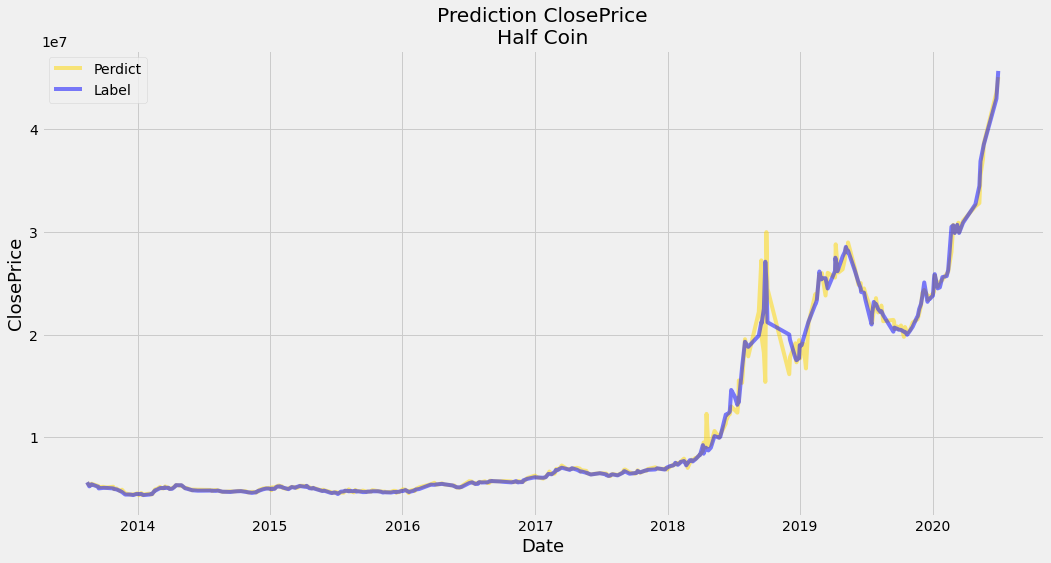

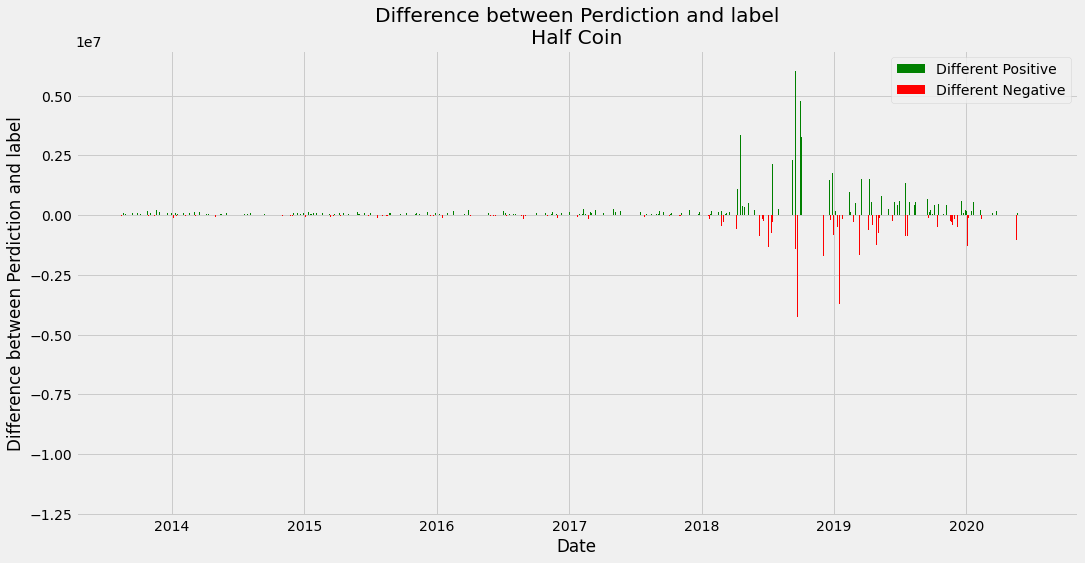

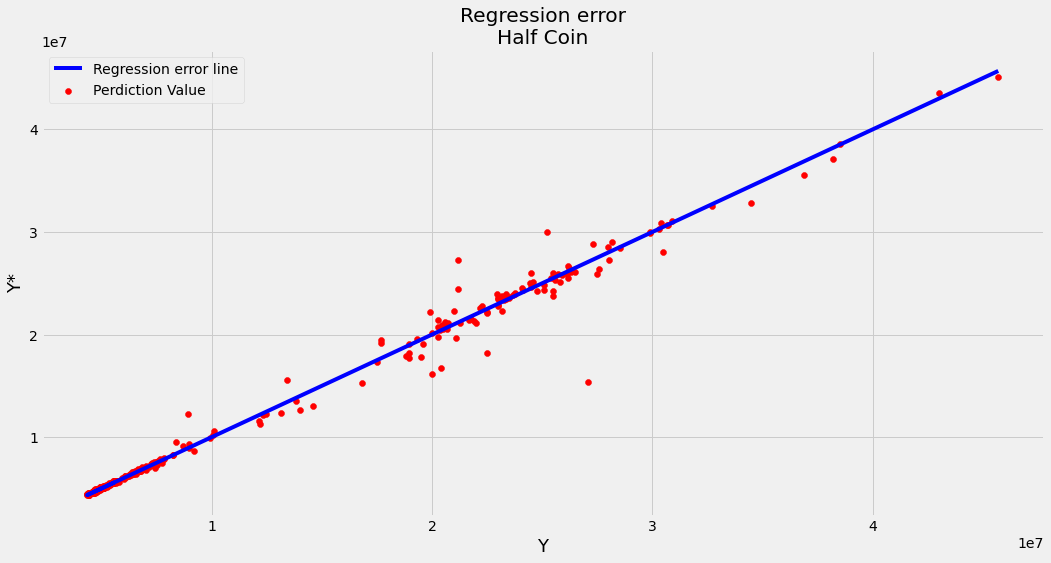

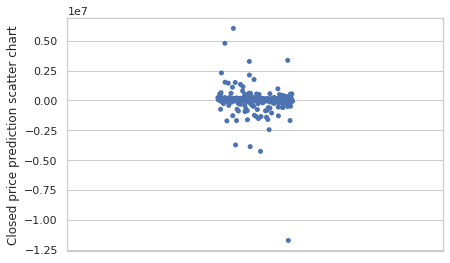

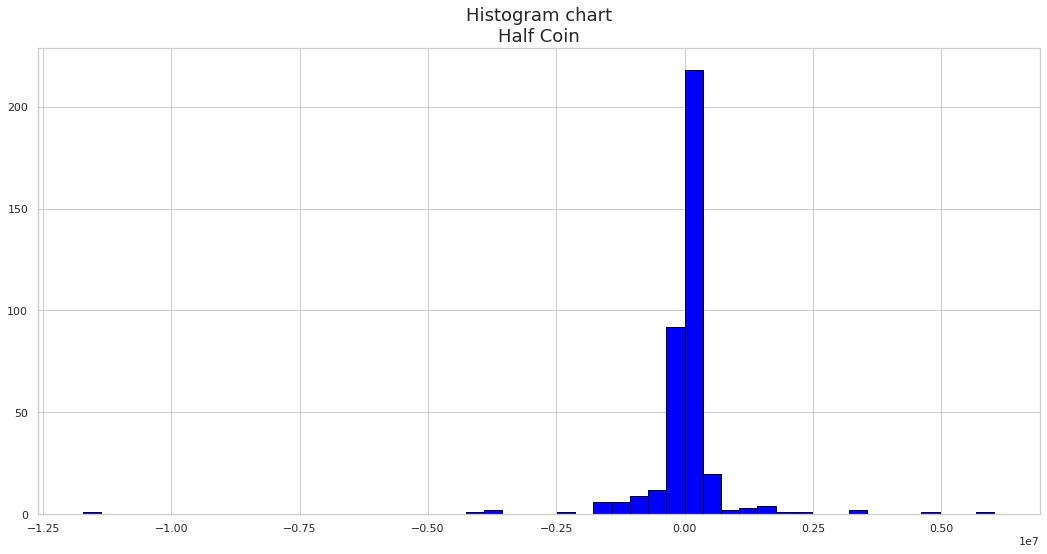

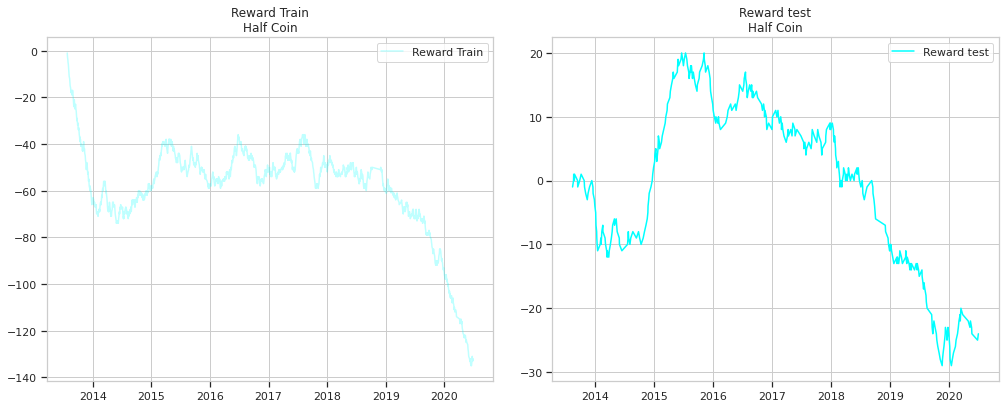

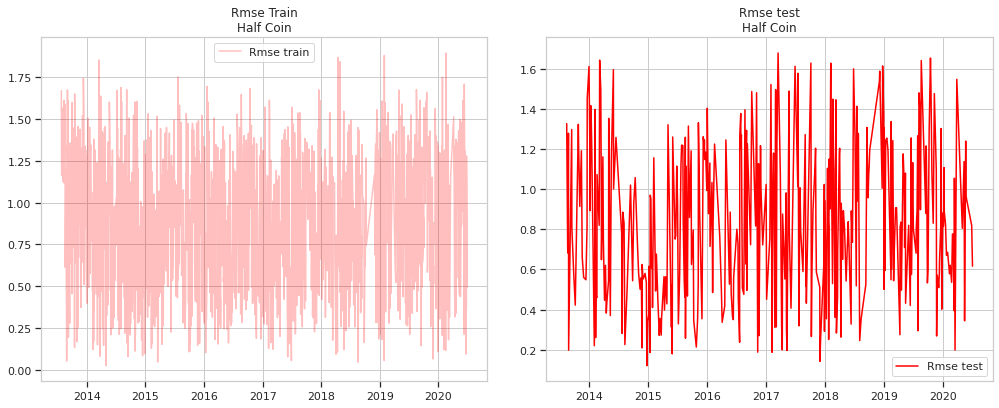

In [ ]:
# -*- coding: utf-8 -*-
"""Predictor with DDqlearning With K_fold.ipynb.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1UxtMoGDJRtsI7-K66IY0ZVYAPB2DmiBD
"""

# Perdict price Gold with Renforcment learning with DDQn
import numpy
from keras.engine.base_layer import TensorFlowOpLayer
!pip install keras
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam # - Works
from numpy import array
from numpy import hstack
from math import sqrt
from numpy import split
from numpy import array
import pandas as pd
import statistics
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import MaxPooling1D
from pandas import read_csv
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from datetime import datetime
import sys
sys.path.append('/content/sample_data')
import Constant
from keras.callbacks import set_callback_parameters
from keras.backend import constant
# Class for disply result and write resul in to file text
# Create ReplayBuffer for deep Q_learning
class ReplayBuffer(object):
    def __init__(self, max_size, n_steps_in,n_output, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size,n_steps_in,4))
        self.new_state_memory = np.zeros((self.mem_size,n_steps_in,4))
        dtype = np.int8 if self.discrete else np.float32
        self.n_output_memory = np.zeros((self.mem_size,n_output),dtype=dtype)
        self.actual_currentState_memory = np.zeros((self.mem_size,n_output),dtype=dtype)
        self.actual_nextState_memory = np.zeros((self.mem_size,n_output),dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)
    def store_transition(self, state,n_output,actual_currentState,actual_nextState,reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index,:] = state
        self.new_state_memory[index,:] = state_
        self.n_output_memory[index,:] = n_output
        self.actual_currentState_memory[index,:] = actual_currentState
        self.actual_nextState_memory[index,:] = actual_nextState
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch,:,:]
        n_output = self.n_output_memory[batch,:]
        actual_currentState = self.actual_currentState_memory[batch,:]
        actual_nextState = self.actual_nextState_memory[batch,:]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch,:,:]
        terminal = self.terminal_memory[batch]
        return states,n_output,actual_currentState,actual_nextState,rewards,states_,terminal
#Creat Agent for deep Q_learning
class Agent(object):
    def __init__(self,gamma,epsilon,n_steps_in,n_steps_out,n_output,batch_size,model,model_target,
                 epsilon_dec=0.996,epsilon_end=0.01,mem_size=1000000, fname='dqn_model.h5',replace_target=100):
        self.action_space = [i for i in range(n_output)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.replace_target=replace_target
        self.memory = ReplayBuffer(mem_size,n_steps_in+1,n_output,discrete=False)
        self.q_eval =model
        self.q_target=model_target
    def remember(self, state,n_output,actual_currentState,actual_nextState,reward, new_state, done):
        self.memory.store_transition(state,n_output,actual_currentState,actual_nextState,reward,new_state, done)
    def Predict_n_output(self,state):
        state=tf.reshape(state,[1,state.shape[0],state.shape[1]])
        n_output = self.q_eval.predict(state)
        return n_output
    def loss_Function(self,actul,q_next):
      loss=[]
      for i in range(len(actul)):
        for j in range(actul.shape[1]):
           loss.append(q_next[i][j]-actul[i][j])
      loss=np.array(loss).reshape(actul.shape[0],actul.shape[1])
      for m in range(len(actul)):
        for n in range(actul.shape[1]):
           q_next[m][n]=q_next[m][n]-loss[m][n]
      return q_next
    def learn(self):
      if self.memory.mem_cntr > self.batch_size:
            state, n_output,actual_currentState,actual_nextState,reward,new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)
            q_pred = self.q_target.predict(new_state)
            q_target = self.q_eval.predict(state)
            self.gamma=1
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            Cloum_index=np.array(self.action_space, dtype=np.int8).reshape(4,1)
            q_next=self.loss_Function(actual_nextState,q_pred)
            q_target[batch_index,Cloum_index.astype(np.int32)]= reward+self.gamma*q_next[batch_index,Cloum_index.astype(np.int32)]*done
            _ = self.q_eval.fit(state,q_target,epochs=10,batch_size=self.batch_size,verbose=0)
            if self.memory.mem_cntr % self.replace_target == 0:
                self.update_network_parameters()
     # update_network_parameters
    def update_network_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())
    # get state
    def get_state(self,Value_X,n_steps_in,reward):
      state=[]
      state1=[]
      count=0
      #print(Value_X.shape)
      if len(Value_X)<n_steps_in:
         count=n_steps_in-len(Value_X)
         for j in range(len(Value_X)):
           state.append(Value_X[j])
         for i in range(count):
            state.append([0,0,0,0])
      else:
          for j in range(len(Value_X)):
            state.append(Value_X[j])
      #print(state)
      state1=np.array(state).reshape(n_steps_in,4)
      #print("State",state1)
      #input()
      state.clear()
      for i in range(len(state1)) :
        state.append(state1[i,:])
      state.append([reward,reward,reward,reward])
      state=np.array(state).reshape(n_steps_in+1,4)
      state=tf.constant(state,dtype=tf.float64)
      #print("state:",state)
      #input()
      return state 
    # retrun reward for agent
    def get_reward(self,actual, predicted,Type_Gold):
      reward=0
      Rmse=0
      #print("actual :",actual)
      #print("predicted :",predicted)
      Rmse=self.evaluate_forecasts(actual,predicted)
      #print("Rmse:",Rmse)
      #input()
      if Rmse<=0.5 and Type_Gold==1:
          reward=1
      elif Rmse<=0.8 and Type_Gold>1:
          reward=1 
      else:
        reward=-1
      return reward,Rmse
    # def Normalization_XY(self,Data):
    #    max1=np.max(Data)
    #    min1=np.min(Data)
    #    max2=1
    #    min2=-1
    #    A=0
    #    Data_normal=[]
    #    for n in range(Data.shape[0]):
    #      for m in range(Data.shape[1]):
    #         try:
    #             A=((float)(Data[n,m])- min1)*(max2- min2)/ (max1 - min1) + min2
    #         except :
    #             A=0
    #         Data_normal.append(A)
    #    Data_normal=np.array(Data_normal).reshape(Data.shape[0],Data.shape[1]) 
    #    return Data_normal 
    def evaluate_forecasts(self,actual,predicted):
      # actual=self.Normalization_XY(actual)
      # predicted=self.Normalization_XY(predicted)
      scaler = MinMaxScaler(feature_range=(-1,1))
      actual = actual.reshape(-1,1)
      actual = scaler.fit_transform(actual)
      predicted = predicted.reshape(-1,1)
      predicted = scaler.fit_transform(predicted)
      # print("actual :", actual)
      # print("predicted", predicted)
      # calculate overall RMSE
      s = 0
      for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
          s += (predicted[row, col] - actual[row, col])**2
      Rmse = sqrt(s / (actual.shape[0] * actual.shape[1]))
      return Rmse
    # retrun action of agent
    def get_n_output_agent(self,current_state):
      n_output_agent=0
      n_output_agent = self.Predict_n_output(current_state)
      return n_output_agent
# Calss for Read Data of file and opertion main program
class Read_Data_Input():
  def __init__(self,File_Name):
    self.File_name=File_Name
  def selection_Data(self,Type_Gold,Dataset):
    a=[]
    for Loop1 in range(Dataset.shape[0]):
      if Dataset[Loop1,0]==Type_Gold :
        a.append(Loop1)
    dataset_Selection=Dataset[a,:]
    return dataset_Selection
  def Windowing(self,sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
      X.append(seq_x)
      y.append(seq_y)
    return array(X), array(y)
  #split Dataset
  def split_Data(self,dataX,dataY,n_folds,Count):
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for train_ix, test_ix in kfold.split(dataX[1:Count:]):
      # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    return trainX, trainY, testX, testY
  def binarySearch (self,arr, l, r, x): 
      if r >= l: 
          mid = l + (r - l) // 2
          if arr[mid] == x: 
              return mid 
          elif arr[mid] > x: 
              return self.binarySearch(arr, l, mid-1, x) 
          else: 
              return self.binarySearch(arr, mid + 1, r, x) 
      else: 
          return -1
  def Calculat_price_fluctuations(self,Data):
    # Variable dif_ClosePrice_With_OpenPrice_Tody
    dif_ClosePrice_With_OpenPrice_Tody=np.zeros((len(Data),1))
    dif_ClosePrice_With_OpenPrice_Tody_Positive=[]
    dif_ClosePrice_With_OpenPrice_Tody_Negative=[]
    dif_ClosePrice_With_OpenPrice_Tody_Abs=[]
    dif_ClosePrice_With_OpenPrice_Tody_Positive_mean=0
    dif_ClosePrice_With_OpenPrice_Tody_Negative_mean=0
    dif_ClosePrice_With_OpenPrice_Tody_Abs_mean=0
    dif_ClosePrice_With_OpenPrice_Tody_Positive_std=0
    dif_ClosePrice_With_OpenPrice_Tody_Negative_std=0
    dif_ClosePrice_With_OpenPrice_Tody_Abs_std=0
    # Variable fluctuations_Today (dif max price Today with min price Today)
    ClosePrice_fluctuations_Today=np.zeros((len(Data),1))
    ClosePrice_fluctuations_Today_mean=0
    ClosePrice_fluctuations_Today_std=0
    # Variable dif_ClosePrice Today With ClosePrice Last day
    dif_ClosePriceToday_With_ClosePrice_Last_day=np.zeros((len(Data)-1,1))
    dif_ClosePriceToday_With_ClosePrice_Last_day_Positive=[]
    dif_ClosePriceToday_With_ClosePrice_Last_day_Negative=[]
    dif_ClosePriceToday_With_ClosePrice_Last_day_Abs=[]
    dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_mean=0
    dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_mean=0
    dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_mean=0
    dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_std=0
    dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_std=0
    dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_std=0
    # Variable dif OpenPrice Today With OpenPrice Last day
    dif_OpenPriceToday_With_OpenPrice_Last_day=np.zeros((len(Data)-1,1))
    dif_OpenPriceToday_With_OpenPrice_Last_day_Positive=[]
    dif_OpenPriceToday_With_OpenPrice_Last_day_Negative=[]
    dif_OpenPriceToday_With_OpenPrice_Last_day_Abs=[]
    dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_mean=0
    dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_mean=0
    dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_mean=0
    dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_std=0
    dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_std=0
    dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_std=0
    # Variable dif Min Price Today With Min Price Last day
    dif_MinPriceToday_With_MinPrice_Last_day=np.zeros((len(Data)-1,1))
    dif_MinPriceToday_With_MinPrice_Last_day_Positive=[]
    dif_MinPriceToday_With_MinPrice_Last_day_Negative=[]
    dif_MinPriceToday_With_MinPrice_Last_day_Abs=[]
    dif_MinPriceToday_With_MinPrice_Last_day_Positive_mean=0
    dif_MinPriceToday_With_MinPrice_Last_day_Negative_mean=0
    dif_MinPriceToday_With_MinPrice_Last_day_Abs_mean=0
    dif_MinPriceToday_With_MinPrice_Last_day_Positive_std=0
    dif_MinPriceToday_With_MinPrice_Last_day_Negative_std=0
    dif_MinPriceToday_With_MinPrice_Last_day_Abs_std=0
    # Variable dif Max Price Today With Max Price Last day
    dif_MaxPriceToday_With_MaxPrice_Last_day=np.zeros((len(Data)-1,1))
    dif_MaxPriceToday_With_MaxPrice_Last_day_Positive=[]
    dif_MaxPriceToday_With_MaxPrice_Last_day_Negative=[]
    dif_MaxPriceToday_With_MaxPrice_Last_day_Abs=[]
    dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_mean=0
    dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_mean=0
    dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_mean=0
    dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_std=0
    dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_std=0
    dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_std=0
    # --------------------------------------------------Calculate dif ClosepriceToday with OpenpriceToday----------------------------------------------
    for i in range(len(Data)):
        dif_ClosePrice_With_OpenPrice_Tody[i,0]=Data[i,6]-Data[i,3]
        if dif_ClosePrice_With_OpenPrice_Tody[i,0]>0 :
          dif_ClosePrice_With_OpenPrice_Tody_Positive.append(dif_ClosePrice_With_OpenPrice_Tody[i,0])
        elif dif_ClosePrice_With_OpenPrice_Tody[i,0]<0 :
          dif_ClosePrice_With_OpenPrice_Tody_Negative.append(dif_ClosePrice_With_OpenPrice_Tody[i,0])
        dif_ClosePrice_With_OpenPrice_Tody_Abs.append(abs(dif_ClosePrice_With_OpenPrice_Tody[i,0]))
        ClosePrice_fluctuations_Today[i,0]=np.max(Data[i,3:])-np.min(Data[i,3:])
    #-------------------------------------- Calculate mean dif ClosePrice_With_OpenPrice_Tody-----------------------------------------------------------------------------------------------------------
    dif_ClosePrice_With_OpenPrice_Tody_Positive_mean=np.mean(np.array(dif_ClosePrice_With_OpenPrice_Tody_Positive), dtype = np.float32)
    dif_ClosePrice_With_OpenPrice_Tody_Negative_mean=np.mean(np.array(dif_ClosePrice_With_OpenPrice_Tody_Negative), dtype = np.float32)
    dif_ClosePrice_With_OpenPrice_Tody_Abs_mean=np.mean(np.array(dif_ClosePrice_With_OpenPrice_Tody_Abs), dtype = np.float32)
                                           # Calculate std dif ClosePrice_With_OpenPrice_Tody
    dif_ClosePrice_With_OpenPrice_Tody_Positive_std=np.std(np.array(dif_ClosePrice_With_OpenPrice_Tody_Positive), dtype = np.float32)
    dif_ClosePrice_With_OpenPrice_Tody_Negative_std=np.std(np.array(dif_ClosePrice_With_OpenPrice_Tody_Negative), dtype = np.float32)
    dif_ClosePrice_With_OpenPrice_Tody_Abs_std=np.std(np.array(dif_ClosePrice_With_OpenPrice_Tody_Abs), dtype = np.float32)
    # print std and mean dif ClosePrice_With_OpenPrice_Tody----------------------------------------------------------------------------------------------------------
    '''print("-----------print std and mean dif Close Price With Open Price Tody---------")
    print("-------------------------------------------------------------------------------")
    print(" mean dif Postive Close Price With Open Price Today is: {:.3f}\n\n mean dif negative Close Price With Open Price Today is: {:.3f}\n\n mean dif abs Close Price With Open Price Today is: {:.3f}\n".format(dif_ClosePrice_With_OpenPrice_Tody_Positive_mean,dif_ClosePrice_With_OpenPrice_Tody_Negative_mean,dif_ClosePrice_With_OpenPrice_Tody_Abs_mean))
    print(" std dif Postive Close Price With Open Price Today is: {:.3f}\n\n std dif negative Close Price With Open Price Today is: {:.3f}\n\n std dif abs Close Price With Open Price Today is: {:.3f}\n".format(dif_ClosePrice_With_OpenPrice_Tody_Positive_std,dif_ClosePrice_With_OpenPrice_Tody_Negative_std,dif_ClosePrice_With_OpenPrice_Tody_Abs_std))'''
    #---------------------------------------Calculat mean dif ClosePrice_fluctuations_Today ------------------------------------------------------------------------------------------------------------------
    ClosePrice_fluctuations_Today_mean=np.mean(ClosePrice_fluctuations_Today)
                                          # Calculat std ClosePrice_fluctuations_Today
    ClosePrice_fluctuations_Today_std=np.nanstd(ClosePrice_fluctuations_Today)
    # print std and mean dif ClosePrice_fluctuations_Today ---------------------------------------------------------------------------------------------------------------
    '''print("----------print std and mean dif (Max Price Today - Min Price Today)-----------")
    print("-------------------------------------------------------------------------------")
    print(" mean Close Price fluctuations Today is (Max Price Today - Min Price Today): {:.3f} \n ".format(ClosePrice_fluctuations_Today_mean))
    print(" std Close Price fluctuations Today is (Max Price Today - Min Price Today):{:.3f}\n ".format(ClosePrice_fluctuations_Today_std))'''
    #----------------------------------------Calculate dif ---------------------------------------------------------------------------------------------------------------- 
    for j in range(1,len(Data)-1,1):
        # ---------------------------------------------Calculate dif Closeprice today with Closeprice Last day.-----------------------------------------------------
        dif_ClosePriceToday_With_ClosePrice_Last_day[j,0]=Data[j,6]-Data[j-1,6]
        dif_ClosePriceToday_With_ClosePrice_Last_day_Abs.append(abs(dif_ClosePriceToday_With_ClosePrice_Last_day[j,0]))
        if dif_ClosePriceToday_With_ClosePrice_Last_day[j,0]>0 :
          dif_ClosePriceToday_With_ClosePrice_Last_day_Positive.append(dif_ClosePriceToday_With_ClosePrice_Last_day[j,0])
        elif dif_ClosePriceToday_With_ClosePrice_Last_day[j,0]<0 :
          dif_ClosePriceToday_With_ClosePrice_Last_day_Negative.append(dif_ClosePriceToday_With_ClosePrice_Last_day[j,0])
        # ----------------------------------------------Calculate dif open price today with open price Last day ------------------------------------------------------
        dif_OpenPriceToday_With_OpenPrice_Last_day[j,0]=Data[j,3]-Data[j-1,3]
        dif_OpenPriceToday_With_OpenPrice_Last_day_Abs.append(abs(dif_OpenPriceToday_With_OpenPrice_Last_day[j,0]))
        if dif_OpenPriceToday_With_OpenPrice_Last_day[j,0]>0 :
          dif_OpenPriceToday_With_OpenPrice_Last_day_Positive.append(dif_OpenPriceToday_With_OpenPrice_Last_day[j,0])
        elif dif_OpenPriceToday_With_OpenPrice_Last_day[j,0]<0 :
          dif_OpenPriceToday_With_OpenPrice_Last_day_Negative.append(dif_OpenPriceToday_With_OpenPrice_Last_day[j,0])
        # ---------------------------------------------Calculate dif min price today with min price Last day.-----------------------------------------------------
        dif_MinPriceToday_With_MinPrice_Last_day[j,0]=np.min(Data[j,3:])-np.min(Data[j-1,3:])
        dif_MinPriceToday_With_MinPrice_Last_day_Abs.append(abs(dif_MinPriceToday_With_MinPrice_Last_day[j,0]))
        if dif_MinPriceToday_With_MinPrice_Last_day[j,0]>0 :
          dif_MinPriceToday_With_MinPrice_Last_day_Positive.append(dif_MinPriceToday_With_MinPrice_Last_day[j,0])
        elif dif_MinPriceToday_With_MinPrice_Last_day[j,0]<0 :
          dif_MinPriceToday_With_MinPrice_Last_day_Negative.append(dif_MinPriceToday_With_MinPrice_Last_day[j,0])
        # ----------------------------------------------Calculate dif Max price today with Max price Last day ------------------------------------------------------
        dif_MaxPriceToday_With_MaxPrice_Last_day[j,0]=np.max(Data[j,3:])-np.min(Data[j-1,3:])
        dif_MaxPriceToday_With_MaxPrice_Last_day_Abs.append(abs(dif_MaxPriceToday_With_MaxPrice_Last_day[j,0]))
        if dif_MaxPriceToday_With_MaxPrice_Last_day[j,0]>0 :
          dif_MaxPriceToday_With_MaxPrice_Last_day_Positive.append(dif_MaxPriceToday_With_MaxPrice_Last_day[j,0])
        elif dif_MaxPriceToday_With_MaxPrice_Last_day[j,0]<0 :
          dif_MaxPriceToday_With_MaxPrice_Last_day_Negative.append(dif_MaxPriceToday_With_MaxPrice_Last_day[j,0])
    # --------------------------------------- Calculate mean dif Closeprice today with Closeprice Last day-----------------------------------------------------------------------------------------------------
    dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_mean=np.mean(np.array(dif_ClosePriceToday_With_ClosePrice_Last_day_Positive), dtype = np.float32)
    dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_mean=np.mean(np.array(dif_ClosePriceToday_With_ClosePrice_Last_day_Negative), dtype = np.float32)
    dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_mean=np.mean(np.array(dif_ClosePriceToday_With_ClosePrice_Last_day_Abs), dtype = np.float32)
                                           # Calculate std dif Closepricetoday with Closeprice Last day
    dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_std=np.std(np.array(dif_ClosePriceToday_With_ClosePrice_Last_day_Positive), dtype = np.float32)
    dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_std=np.std(np.array(dif_ClosePriceToday_With_ClosePrice_Last_day_Negative), dtype = np.float32)
    dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_std=np.std(np.array(dif_ClosePriceToday_With_ClosePrice_Last_day_Abs), dtype = np.float32)
    # print std and mean dif Closeprice today with Closeprice Last day ---------------------------------------------------------------------------------------------------
    '''print("----print std and mean dif Close price today with Close price Last day-----")
    print("-------------------------------------------------------------------------------")
    print(" mean dif Postive Close Price today with Close Price Last day is: {:.3f} \n\n mean dif negative Close Price today with Close Price Last day is: {:.3f} \n\n mean dif abs Close Price today with ClosePrice Last day is: {:.3f}\n".format(dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_mean,dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_mean,dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_mean))
    print(" std dif Postive Close price today with Close Price Last day is: {:.3f} \n\n std dif negative Close Price today with Close Price Last day is: {:.3f} \n\n std dif abs Close Price today with Close Price Last day is: {:.3f}\n".format(dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_std,dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_std,dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_std))'''
    # ---------------------------------------Calculate mean dif OpenPriceToday_With_OpenPrice last day --------------------------------------------------------------------------------------------------------
    dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_mean=np.mean(np.array(dif_OpenPriceToday_With_OpenPrice_Last_day_Positive), dtype = np.float32)
    dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_mean=np.mean(np.array(dif_OpenPriceToday_With_OpenPrice_Last_day_Negative), dtype = np.float32)
    dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_mean=np.mean(np.array(dif_OpenPriceToday_With_OpenPrice_Last_day_Abs), dtype = np.float32)
                                           # Calculate std dif OpenPriceToday_With_OpenPriceTomaro
    dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_std=np.std(np.array(dif_OpenPriceToday_With_OpenPrice_Last_day_Positive), dtype = np.float32)
    dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_std=np.std(np.array(dif_OpenPriceToday_With_OpenPrice_Last_day_Negative), dtype = np.float32)
    dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_std=np.std(np.array(dif_OpenPriceToday_With_OpenPrice_Last_day_Abs), dtype = np.float32)
    # print std and mean dif OpenPriceToday_With_Open Price Last day --------------------------------------------------------------------------------------------------------
    '''print("-----print std and mean dif Open PriceToday With Open Price Last day------")
    print("-------------------------------------------------------------------------------")
    print(" mean dif Postive Open Price today with Open Price Last day is: {:.3f} \n\n mean dif negative Open Price today with Open Price Last day is: {:.3f} \n\n mean dif abs Open Price today with Open Price Last day is: {:.3f}\n".format(dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_mean,dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_mean,dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_mean))
    print(" std dif Postive Open Price today with Open Price Last day  is: {:.3f} \n\n std dif negative Open Price today with Open Price Last day is: {:.3f} \n\n std dif abs Open Price today with Open Price Last day is: {:.3f}\n".format(dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_std,dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_std,dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_std))'''
    # --------------------------------------- Calculate mean dif Min price today with Min price Last day-----------------------------------------------------------------------------------------------------
    dif_MinPriceToday_With_MinPrice_Last_day_Positive_mean=np.mean(np.array(dif_MinPriceToday_With_MinPrice_Last_day_Positive), dtype = np.float32)
    dif_MinPriceToday_With_MinPrice_Last_day_Negative_mean=np.mean(np.array(dif_MinPriceToday_With_MinPrice_Last_day_Negative), dtype = np.float32)
    dif_MinPriceToday_With_MinPrice_Last_day_Abs_mean=np.mean(np.array(dif_MinPriceToday_With_MinPrice_Last_day_Abs), dtype = np.float32)
                                           # Calculate std dif Closepricetoday with Closeprice Last day
    dif_MinPriceToday_With_MinPrice_Last_day_Positive_std=np.std(np.array(dif_MinPriceToday_With_MinPrice_Last_day_Positive), dtype = np.float32)
    dif_MinPriceToday_With_MinPrice_Last_day_Negative_std=np.std(np.array(dif_MinPriceToday_With_MinPrice_Last_day_Negative), dtype = np.float32)
    dif_MinPriceToday_With_MinPrice_Last_day_Abs_std=np.std(np.array(dif_MinPriceToday_With_MinPrice_Last_day_Abs), dtype = np.float32)
    # print std and mean dif Min price today with Min price Last day ---------------------------------------------------------------------------------------------------
    '''print("-----print std and mean dif Min price today with Min price Last day-------")
    print("-------------------------------------------------------------------------------")
    print(" mean dif Postive Min Price today with Min Price Last day is: {:.3f} \n\n mean dif negative Min Price today with Min Price Last day is: {:.3f} \n\n mean dif abs Min Price today with Min Price Last day is: {:.3f}\n".format(dif_MinPriceToday_With_MinPrice_Last_day_Positive_mean,dif_MinPriceToday_With_MinPrice_Last_day_Negative_mean,dif_MinPriceToday_With_MinPrice_Last_day_Abs_mean))
    print(" std dif Postive Min price today with Min Price Last day is: {:.3f} \n\n std dif negative Min Price today with Min Price Last day is: {:.3f} \n\n std dif abs Min Price today with Min Price Last day is: {:.3f}\n".format(dif_MinPriceToday_With_MinPrice_Last_day_Positive_std,dif_MinPriceToday_With_MinPrice_Last_day_Negative_std,dif_MinPriceToday_With_MinPrice_Last_day_Abs_std))'''
    # ---------------------------------------Calculate mean dif Max Price Today_With_Max Price last day --------------------------------------------------------------------------------------------------------
    dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_mean=np.mean(np.array(dif_MaxPriceToday_With_MaxPrice_Last_day_Positive), dtype = np.float32)
    dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_mean=np.mean(np.array(dif_MaxPriceToday_With_MaxPrice_Last_day_Negative), dtype = np.float32)
    dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_mean=np.mean(np.array(dif_MaxPriceToday_With_MaxPrice_Last_day_Abs), dtype = np.float32)
                                           # Calculate std dif OpenPriceToday_With_OpenPriceTomaro
    dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_std=np.std(np.array(dif_MaxPriceToday_With_MaxPrice_Last_day_Positive), dtype = np.float32)
    dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_std=np.std(np.array(dif_MaxPriceToday_With_MaxPrice_Last_day_Negative), dtype = np.float32)
    dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_std=np.std(np.array(dif_MaxPriceToday_With_MaxPrice_Last_day_Abs), dtype = np.float32)
    # print std and mean dif Max PriceToday_With_Max Price Last day --------------------------------------------------------------------------------------------------------
    '''print("------print std and mean dif Max PriceToday With Max Price Last day------")
    print("-------------------------------------------------------------------------------")
    print(" mean dif Postive Max Price today with Max Price Last day is: {:.3f} \n\n mean dif negative Max Price today with Max Price Last day is: {:.3f} \n\n mean dif abs Max Price today with Max Price Last day is: {:.3f}\n".format(dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_mean,dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_mean,dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_mean))
    print(" std dif Postive Max Price today with Max Price Last day  is: {:.3f} \n\n std dif negative Max Price today with Max Price Last day is: {:.3f} \n\n std dif abs Max Price today with Max Price Last day is: {:.3f}\n".format(dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_std,dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_std,dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_std))'''
    #---------------------------------------------------------------------
    dic={"Mean Pos":[dif_ClosePrice_With_OpenPrice_Tody_Positive_mean,dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_mean,dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_mean,dif_MinPriceToday_With_MinPrice_Last_day_Positive_mean,dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_mean,0],
         "deviation Pos":[dif_ClosePrice_With_OpenPrice_Tody_Positive_std,dif_ClosePriceToday_With_ClosePrice_Last_day_Positive_std,dif_OpenPriceToday_With_OpenPrice_Last_day_Positive_std,dif_MinPriceToday_With_MinPrice_Last_day_Positive_std,dif_MaxPriceToday_With_MaxPrice_Last_day_Positive_std,0],
         "Mean Neg":[dif_ClosePrice_With_OpenPrice_Tody_Negative_mean,dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_mean,dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_mean,dif_MinPriceToday_With_MinPrice_Last_day_Negative_mean,dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_mean,0],
         "deviation Neg":[dif_ClosePrice_With_OpenPrice_Tody_Negative_std,dif_ClosePriceToday_With_ClosePrice_Last_day_Negative_std,dif_OpenPriceToday_With_OpenPrice_Last_day_Negative_std,dif_MinPriceToday_With_MinPrice_Last_day_Negative_std,dif_MaxPriceToday_With_MaxPrice_Last_day_Negative_std,0],
         "Mean Abs":[dif_ClosePrice_With_OpenPrice_Tody_Abs_mean,dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_mean,dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_mean,dif_MinPriceToday_With_MinPrice_Last_day_Abs_mean,dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_mean,0],
         "deviation Abs":[dif_ClosePrice_With_OpenPrice_Tody_Abs_std,dif_ClosePriceToday_With_ClosePrice_Last_day_Abs_std,dif_OpenPriceToday_With_OpenPrice_Last_day_Abs_std,dif_MinPriceToday_With_MinPrice_Last_day_Abs_std,dif_MaxPriceToday_With_MaxPrice_Last_day_Abs_std,0],
         "Mean":[0,0,0,0,0,ClosePrice_fluctuations_Today_mean],
         "deviation":[0,0,0,0,0,ClosePrice_fluctuations_Today_std]}
    index_datafram=["DclosT_w_openT","DclosT_w_closL","DopenT_w_openL","DminT_w_minL","DmaxT_w_maxL","D(maxT-minT)"]
    statistics=pd.DataFrame(dic,index=index_datafram)
    #print(statistics)
    #input()
    return statistics
  def Read_Data(self):
    dataset = read_csv(self.File_name, header=0,encoding='unicode_escape',infer_datetime_format=True,index_col=False)
    dataset.set_index('MiladiDate')
    dataset=dataset.loc[:,['CommodityID','CommodityName','MiladiDate','OpenPrice','LowPrice','HighPrice','ClosePrice']]
    dataset=np.array(dataset)
    q=Constant.nothing
    index=Constant.nothing
    train_dataset=Constant.nothing
    Trad_dataset=Constant.nothing
    find=-1
    Count_Day=Constant.nothing
    n_output=4
    n_features=4
    while(q==0):
      Type_Gold=(int)(input('''Please select the type of gold to predict in the coming days
                    #Value 1 as "اونس طلا"
                    #Value 2 as   "مظنه"
                    #Value 3 as "طلای 18 عیار"
                    #Value 4 as "سکه امامی" 
                    #Value 6 as "نیم سکه"
                    #Value 7 as "ربع سکه"
                    #Value 8 as "سکه گرمی"\n:'''))
      if Type_Gold==1 or Type_Gold==2 or Type_Gold==3 or Type_Gold==4 or Type_Gold==6 or Type_Gold==7 or Type_Gold==8 :
        q=1
      else:
        print("Input value is invalid")
        q=0
    Selection_Dataset=self.selection_Data(Type_Gold,dataset)
    statistics=self.Calculat_price_fluctuations(Selection_Dataset)
    #print(statistics)
    #input()
    Count_Day=len(Selection_Dataset)
    n_folds=(int)(input('Enter N For Split Data Width K_fold :'))
    n=(int)(input('please enter size window(n_steps_in) for trian :'))
    m=(int)(input('Please enter the number (n_steps_out) be predicted:'))
    Selection_Dataset=Selection_Dataset[:Count_Day,:]
    n_steps_in,n_steps_out = n,m
    Count=len(Selection_Dataset)
    x,y=self.Windowing(Selection_Dataset,n_steps_in,n_steps_out)
    x_train,y_train,x_test,y_test=self.split_Data(x,y,n_folds,Count)
    '''x_test=x_test.reshape(x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3])
    y_test=y_test.reshape(y_test.shape[0]*y_test.shape[1],y_test.shape[2],y_test.shape[3])
    x_train=x_train.reshape(x_train.shape[0]*x_train.shape[1],x_train.shape[2],x_train.shape[3])
    y_train=y_train.reshape(y_train.shape[0]*y_train.shape[1],y_train.shape[2],y_train.shape[3])
    print("x_train :")
    print(x_train.shape)
    print("y_train :")
    print(y_train.shape)
    print("x_test :")
    print(x_test.shape)
    print("y_test :")
    print(y_test.shape)
    input()'''
    return n_steps_in,n_features,n_steps_out,x_train,y_train,x_test,y_test,Type_Gold,n_output
# Class for predict Data
class class_Perdictor():
  def __init__(self,name):
    self.name=name
  def Calculate_Average_differences(self,p_w_difference):
    Averge_differences=0
    difference=np.zeros((len(p_w_difference),1))
    for i in range(len(p_w_difference)):
      difference[i,0]=abs(p_w_difference[i,0])
    Averge_differences=np.mean(difference)
    return Averge_differences
  def Creat_FileName(self,Type_Gold):
    File_Name=""
    if Type_Gold==1:
      File_Name='Predict_Model_Ounce_of_Gold.h5'
    if Type_Gold==2:
      File_Name='Predict_Model_Gold_Quotes.h5'
    if Type_Gold==3:
      File_Name='Predict_Model_18_Carat_Gold.h5'
    if Type_Gold==4:
      File_Name='Predict_Model_Coin_of_Emami.h5'
    if Type_Gold==6:
      File_Name='Predict_Model_Half_Coin.h5'
    if Type_Gold==7:
      File_Name='Predict_Model_Quarter_Coins.h5'
    if Type_Gold==8:
      File_Name='Predict_Model_Hot_Coin.h5'
    return File_Name
  def Perdictor(self,model,model_target,n_steps_in,n_steps_out,n_output,x_train,y_train,x_test,y_test,Type_Gold):
    MaxReward=0
    agent=Constant.nothing
    level=Constant.nothing
    p_w_Perdict_train=np.zeros((len(x_train),4))
    p_w_Perdict_test=np.zeros((len(x_test),4))
    p_w_Label_train=np.zeros((len(x_train),4))
    p_w_Label_test=np.zeros((len(x_test),4))
    p_w_Reward_train=np.zeros((len(x_train),1))
    p_w_Reward_test=np.zeros((len(x_test),1))
    p_w_difference_train=np.zeros((len(x_train),1))
    p_w_difference_test=np.zeros((len(x_test),1))
    Date_Predict_train=np.zeros((len(x_train),1))
    Date_Predict_test=np.zeros((len(x_test),1))
    Rmse_train=np.zeros((len(x_train),1))
    Rmse_test=np.zeros((len(x_test),1))
    Average_of_total_differences_train=0
    Average_of_total_differences_test=0
    Model_filename=self.Creat_FileName(Type_Gold)
    finish_Train=False
    Early_Reward= -100000
    y1=y_test[:,:,2:]
    agent = Agent(gamma=0.99,epsilon=0.0,n_steps_in=n_steps_in,n_steps_out=n_steps_out,n_output=n_output,model=model,model_target=model_target, mem_size=1000000,batch_size=64,epsilon_end=0.0)
    # p_w_Perdict_train,p_w_Label_train,p_w_Reward_train,p_w_difference_train,MaxReward,Date_Predict_train,Rmse_train= self.Trian_Model(agent,n_steps_in,x_train[:,:,3:],y_train[:,:,2:],Type_Gold)
    # Early_Reward = MaxReward
    # Early_rmse_total = agent.evaluate_forecasts(p_w_Label_train,p_w_Perdict_train)*100
    while finish_Train==False  :
      level=level+1
      p_w_Perdict_train,p_w_Label_train,p_w_Reward_train,p_w_difference_train,MaxReward,Date_Predict_train,Rmse_train= self.Trian_Model(agent,n_steps_in,x_train[:,:,3:],y_train[:,:,2:],Type_Gold)
      Average_of_total_differences_train=self.Calculate_Average_differences(p_w_difference_train)
      total_rmse = agent.evaluate_forecasts(p_w_Label_train,p_w_Perdict_train)*100
      if MaxReward <= Early_Reward:
          finish_Train=True
          self.save_model(model,Model_filename)
      Early_Reward = MaxReward
      print("Complete the training in the Step:{} and MaxReward :{} and RMSE_total :{}".format(level,MaxReward,total_rmse))
      print("------------------------------------------------------")
    print("Complete the training , and Rmse step Train is :%{:.3f}, and Averge of Totall Diffrences Close price Prediction with Close price Label is :{:.3f}".format(agent.evaluate_forecasts(p_w_Label_train,p_w_Perdict_train)* 100.0,Average_of_total_differences_train))
    print("------------------------------------------------------")
    p_w_Perdict_test,p_w_Label_test,p_w_Reward_test,p_w_difference_test,Date_Predict_test,Rmse_test=self.Test_model(agent,n_steps_in,MaxReward,x_test[:,:,3:],y_test[:,:,2:],Type_Gold)
    Average_of_total_differences_test=self.Calculate_Average_differences(p_w_difference_test)
    print("Complete the Testing , and Rmse step Test is :%{:.3f}, and Averge of Totall Diffrences Close price Prediction with Close price Label is :{:.3f}".format(agent.evaluate_forecasts(p_w_Label_test,p_w_Perdict_test)* 100.0,Average_of_total_differences_test))
    label_Test=np.array(y1).reshape(y_test.shape[0]*y_test.shape[1],5)
    #print(label_Test)
    #print(p_w_Perdict_test)
    s=""
    if Type_Gold==1:
      s='\n'+'Ounce of Gold'
    if Type_Gold==2:
      s='\n'+'Gold Quotes'
    if Type_Gold==3:
      s='\n'+'18 Carat Gold'
    if Type_Gold==4:
      s='\n'+'Coin of Emami'
    if Type_Gold==6:
      s='\n'+'Half Coin'
    if Type_Gold==7:
      s='\n'+'Quarter Coins'
    if Type_Gold==8:
      s='\n'+'Hot Coin'
    Title='Prediction ClosePrice'+s
    plt.style.use('fivethirtyeight')
    A=pd.to_datetime(Date_Predict_test[:len(Date_Predict_test)-1,0],format='%Y%m%d',errors='coerce')
    plt.figure(figsize=(16,8))
    plt.title(Title)
    plt.plot(A,p_w_Perdict_test[:len(p_w_Perdict_test)-1,3].astype(np.int64), label='Perdict', color = 'Gold', alpha = 0.50)
    plt.plot(A,p_w_Label_test[:len(p_w_Label_test)-1,3].astype(np.int64), label='Label', color = 'Blue', alpha = 0.50)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('ClosePrice',fontsize=18)
    plt.legend(loc='upper left') 
    plt.show()
    # show Diagram Different
    print()
    plt.figure(figsize=(16,8))
    Defrent_Negative=[]
    Defrent_Postive=[]
    Date_Defrent_Negative=[]
    Date_Defrent_Postive=[]
    for t in range(len(p_w_Perdict_test)-1):
      if (float)(p_w_difference_test[t,:])>0 :
          Defrent_Postive.append(p_w_difference_test[t,0])
          Date_Defrent_Postive.append(A[t])        
      else :
          Defrent_Negative.append(p_w_difference_test[t,0])
          Date_Defrent_Negative.append(A[t])
    plt.bar(Date_Defrent_Postive,Defrent_Postive, color = 'green', label='Different Positive',width=2)
    plt.bar(Date_Defrent_Negative,Defrent_Negative, color = 'red', label='Different Negative',width=2)
    plt.xlabel('Date')
    plt.ylabel("Difference between Perdiction and label")
    plt.title("Difference between Perdiction and label"+s)
    plt.legend()
    plt.show()
    # Show Diagram Regression error
    print()
    plt.figure(figsize=(16,8)) 
    plt.title("Regression error"+s)
    plt.scatter(p_w_Label_test[:len(p_w_Label_test)-1,3],p_w_Perdict_test[:len(p_w_Perdict_test)-1,3],label='Perdiction Value',color = 'red')
    plt.plot(p_w_Label_test[:len(p_w_Label_test)-1,3],p_w_Label_test[:len(p_w_Label_test)-1,3],label='Regression error line',color = 'blue')
    plt.xlabel('Y',fontsize=18)
    plt.ylabel('Y*',fontsize=18)
    plt.legend(loc='upper left') 
    plt.show()
    print()    
    # Show Diagram Scatter plot
    sns.set_theme(style="whitegrid")
    dic={"Closed price prediction scatter chart":p_w_difference_test[:,0]}
    df=pd.DataFrame(dic)
    #print(df)
    ax = sns.stripplot(y=df["Closed price prediction scatter chart"],)
    print()    
    # Show Diagram Histogram chart
    plt.figure(figsize=(16,8)) 
    plt.title("Histogram chart"+s,fontsize=18)
    plt.hist(p_w_difference_test[:,0], bins =50,color = 'blue', edgecolor = 'black')
    plt.show()
    # Show diagram Reward agent in step Train and step test
    print()
    plt.rcParams['figure.figsize']=(16,12)
    ax1=plt.subplot2grid((10,20),(0,0),rowspan=5,colspan=9)
    ax2=plt.subplot2grid((10,20),(0,10),rowspan=5,colspan=9)
    A=pd.to_datetime(Date_Predict_test[:len(Date_Predict_test)-1,0],format='%Y%m%d',errors='coerce')
    b=pd.to_datetime(Date_Predict_train[:len(Date_Predict_train)-1,0],format='%Y%m%d',errors='coerce')
    ax1.plot(b,p_w_Reward_train[:len(p_w_Reward_train)-1,0], label='Reward Train', color = 'cyan', alpha = 0.25)
    ax2.plot(A,p_w_Reward_test[:len(p_w_Reward_test)-1,0], label='Reward test', color = 'cyan', alpha = 1)
    ax1.set_title("Reward Train"+s)
    ax2.set_title("Reward test"+s)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    ax1.legend()
    ax2.legend()
    plt.show()
    print()
    # show Diagram Rmse
    plt.rcParams['figure.figsize']=(16,12)
    ax1=plt.subplot2grid((10,20),(0,0),rowspan=5,colspan=9)
    ax2=plt.subplot2grid((10,20),(0,10),rowspan=5,colspan=9)
    A=pd.to_datetime(Date_Predict_test[:len(Date_Predict_test)-1,0],format='%Y%m%d',errors='coerce')
    b=pd.to_datetime(Date_Predict_train[:len(Date_Predict_train)-1,0],format='%Y%m%d',errors='coerce')
    ax1.plot(b,Rmse_train[:len(Rmse_train)-1,0], label='Rmse train', color = 'Red', alpha = 0.25)
    ax2.plot(A,Rmse_test[:len(Rmse_test)-1,0], label='Rmse test', color = 'Red', alpha = 1)
    ax1.set_title("Rmse Train"+s)
    ax2.set_title("Rmse test"+s)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    ax1.legend()
    ax2.legend()
    plt.show()
  def save_model(self,model,filename):
      s="/content/sample_data/"+filename
      model.save(s)
  def load_model(self,filename):
      model=Constant.nothing
      is_Model=False
      try :
        s="/content/sample_data/"+filename
        model = load_model(s)
        is_Model=True
      except :
        is_Model=False
      return model,is_Model 
  # Create model for deep Q_learning
  def build_dqn(self,n_steps_in,n_features,n_output):
      model = Sequential()
      model.add(LSTM(200, activation='relu',input_shape=(n_steps_in+1, n_features)))
      model.add(RepeatVector(n_output))
      model.add(LSTM(200, activation='relu', return_sequences=True))
      model.add(Conv1D(filters=64, kernel_size=n_output, activation='relu'))
      model.add(MaxPooling1D(pool_size=1))
      model.add(Flatten())
      model.add(Dense(50, activation='relu'))
      model.add(Dense(n_output))
      model.compile(optimizer='adam', loss='mse',metrics=["accuracy"])
      #print(model.summary())
      return model
  def Test_model(self,agent,n_steps_in,MaxReward,x_test,y_test,Type_Gold):
    done=False
    predicted=Constant.nothing
    reward=Constant.nothing
    Total_reward= 0
    Rmse=Constant.nothing
    count=len(x_test)
    p_w_Perdict=np.zeros((count,4))
    p_w_Label=np.zeros((count,4))
    p_w_Reward=np.zeros((count,1))
    p_w_difference=np.zeros((count,1))
    Date_Predict=np.zeros((count,1))
    Rmse_test=np.zeros((count,1))
    for i in range(count-1):
        current_state=agent.get_state(np.array(x_test[i,:,:]).reshape(x_test.shape[1],x_test.shape[2]),n_steps_in,reward)
        predicted=agent.get_n_output_agent(current_state)
        # print("predcte :",predicted)
        #print("x_test :",x_test,x_test.shape)
        #print("y_test :",y_test,y_test.shape[0])
        #input()
        label_currentState=np.array(y_test[i,:,1:])
        label_nextState=np.array(y_test[i+1,:,1:])
        # print("label Current state",label_currentState)
        #print("label next state",label_nextState)
  
        reward,Rmse=agent.get_reward(label_currentState,predicted,Type_Gold)
        #print("label:",label_currentState)
        # print("Predict:",predicted)
        # print("Rmse:",(float)(Rmse))
        # input()
        Total_reward +=reward
        next_state=agent.get_state(np.array(x_test[i+1,:,:]).reshape(x_test.shape[1],x_test.shape[2]),n_steps_in,reward)
        agent.remember(current_state,predicted,label_currentState,label_nextState,reward,next_state,int(done))
        agent.learn()
        p_w_Perdict[i,:]=predicted
        p_w_Label[i,:]=label_currentState
        p_w_Reward[i,:]=Total_reward
        p_w_difference[i,:]=(predicted[:,3]-label_currentState[:,3])
        # print("Dif-Test: ",p_w_difference[i,0])
        Date_Predict[i,:]=y_test[i,:,0]
        Rmse_test[i,:]=Rmse
    return  p_w_Perdict,p_w_Label,p_w_Reward,p_w_difference ,Date_Predict,Rmse_test
  def Trian_Model(self,agent,n_steps_in,x_train,y_train,Type_Gold):
    done=False
    predicted=Constant.nothing
    reward=Constant.nothing
    Total_reward=Constant.nothing
    Rmse=Constant.nothing
    count=len(x_train)
    p_w_Perdict=np.zeros((count,4))
    p_w_Label=np.zeros((count,4))
    p_w_Reward=np.zeros((count,1))
    p_w_difference=np.zeros((count,1))
    Date_Predict=np.zeros((count,1))
    Rmse_train=np.zeros((count,1))
    for i in range(count-1):
      current_state=agent.get_state(np.array(x_train[i,:,:]).reshape(x_train.shape[1],x_train.shape[2]),n_steps_in,reward)
      predicted=agent.get_n_output_agent(current_state)
      #print("x_train :",x_train,x_train.shape)
      #print("y_train :",y_train,y_train.shape)
      #input()
      label_currentState=np.array(y_train[i,:,1:])
      label_nextState=np.array(y_train[i+1,:,1:])
      # print("label:",label_currentState)
      #input()
      reward,Rmse=agent.get_reward(label_currentState,predicted,Type_Gold)
      #print("label:",label_currentState)
      # print("Predict:",predicted)
      # print("Rmse:",(float)(Rmse))
      # input()
      Total_reward+=reward
      next_state=agent.get_state(np.array(x_train[i+1,:,:]).reshape(x_train.shape[1],x_train.shape[2]),n_steps_in,reward)
      agent.remember(current_state, predicted,label_currentState,label_nextState,reward,next_state, int(done))
      agent.learn()
      p_w_Perdict[i,:]=predicted
      p_w_Label[i,:]=label_currentState
      p_w_Reward[i,:]=Total_reward
      p_w_difference[i,:]=(predicted[:,3]-label_currentState[:,3])
      # print("DifTrain: ",p_w_difference[i,0])
      Date_Predict[i,:]=y_train[i,:,0]
      Rmse_train[i,:]=Rmse
    return p_w_Perdict,p_w_Label,p_w_Reward,p_w_difference,Total_reward,Date_Predict,Rmse_train 
if __name__== "__main__" :
  Read_Obj=Read_Data_Input("/content/sample_data/AllData.csv")
  Predictor_Obj=class_Perdictor("Predictor")
  n_steps_in=Constant.nothing
  n_features=Constant.nothing
  n_steps_out=Constant.nothing
  n_output=Constant.nothing
  model=Constant.nothing
  model_target=Constant.nothing
  n_steps_in,n_features,n_steps_out,x_train,y_train,x_test,y_test,Type_Gold,n_output=Read_Obj.Read_Data()
  #print(len(x_train),len(y_train),len(x_test),len(y_test))
  #print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
  #print(n_features)
  print("start Train Model Deep-qlearning...........")
  model=Predictor_Obj.build_dqn(n_steps_in, n_features,n_output)
  model_target=Predictor_Obj.build_dqn(n_steps_in,n_features,n_output)
  Predictor_Obj.Perdictor(model,model_target,n_steps_in,n_steps_out,n_output,x_train,y_train,x_test,y_test,Type_Gold)